In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [4]:
import scripts.image_label_loader as iml

data_dir = '../Datasets/X-Ray/scoliosis'
train_images, train_labels = iml.load_images_and_labels(data_dir, 'train')
valid_images, valid_labels = iml.load_images_and_labels(data_dir, 'valid')
test_images, test_labels = iml.load_images_and_labels(data_dir, 'test')

print(f'Train images: {len(train_images)}, Train labels: {len(train_labels)}')
print(f'Train shape {train_images[0].shape}')
print(f'Valid images: {len(valid_images)}, Valid labels: {len(valid_labels)}')
print(f'Test images: {len(test_images)}, Test labels: {len(test_labels)}')

train_images = np.array(train_images).astype(np.float32)
train_labels = np.array(train_labels).astype(np.float32)
test_images = np.array(test_images).astype(np.float32)
test_labels = np.array(test_labels).astype(np.float32)
valid_images = np.array(valid_images).astype(np.float32)
valid_labels = np.array(valid_labels).astype(np.float32)

train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

Train images: 862, Train labels: 862
Train shape (120, 60, 3)
Valid images: 100, Valid labels: 100
Test images: 100, Test labels: 100


# Cel
Naszym celem będzie za pomocą filtrów obrazów sprawić by kości kręgosłupa były bardziej widoczne, co nam się przyda na później (sam nie wiem po co)

[[[0.00784314 0.00784314 0.00784314]
  [0.         0.         0.        ]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.         0.         0.        ]
  [0.03529412 0.03529412 0.03529412]
  [0.         0.         0.        ]]

 [[0.01176471 0.01176471 0.01176471]
  [0.00392157 0.00392157 0.00392157]
  [0.05490196 0.05490196 0.05490196]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.07058824 0.07058824 0.07058824]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.07450981 0.07450981 0.07450981]
  ...
  [0.07058824 0.07058824 0.07058824]
  [0.11372549 0.11372549 0.11372549]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.05490196 0.05490196 0.05490196]
  [0.31764707 0.31764707 0.31764707]
  [0.5529412  0.5529412  0.5529412 ]
  ...
  [0.12156863 0.12156863 0.12156863]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.06666667 0.06666667 0.06666667]


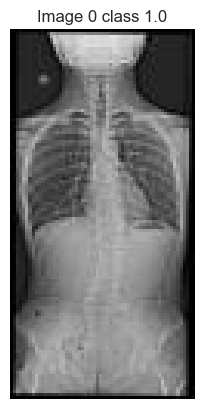

In [5]:
print(train_images[0])
plt.imshow(train_images[0])
print(f"wymiary {train_images[0].shape}")
plt.title(f'Image {0} class {train_labels[0]}') 
plt.axis('off')  
plt.show()
image = train_images[0]

Wyostrzanie obrazu (tak sobie działa)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


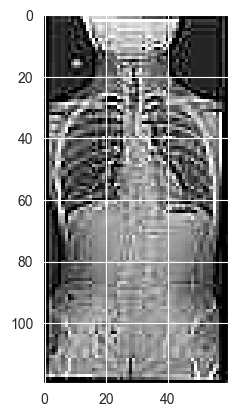

In [49]:
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
image_f = cv2.filter2D(image, -1, kernel_sharpen)
plt.imshow(image_f)

Filtr Dolnoprzepustowy (Bezużyteczny) i górnoprzepustowy 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


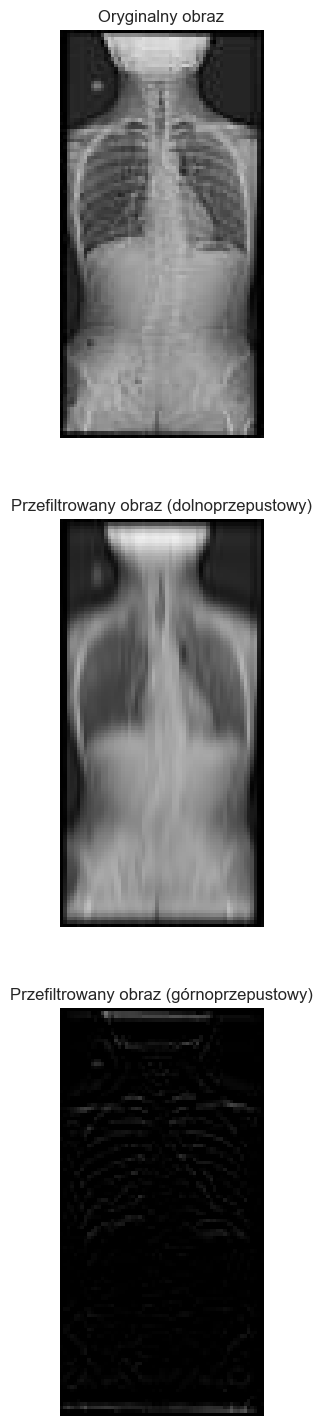

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Definicja funkcji filtru dolnoprzepustowego
def butter_filter(data, cutoff, fs, btype, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data, axis=0)  # Przefiltrowanie wzdłuż pierwszej osi
    return y

# Parametry filtru
cutoff = 0.1
fs = 1.0
order = 4

# Przefiltrowanie każdego kanału osobno
filtered_image_low = np.zeros_like(image)
filtered_image_high = np.zeros_like(image)
for i in range(3):  # Iteracja przez kanały R, G, B
    filtered_image_low[:, :, i] = butter_filter(image[:, :, i], cutoff, fs,'low', order)
    filtered_image_high[:, :, i] = butter_filter(image[:, :, i], cutoff, fs,'high', order)

plt.figure(figsize=(8, 18))  # Zwiększona wysokość dla lepszego wyświetlania

plt.subplot(3, 1, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(filtered_image_low)
plt.title('Przefiltrowany obraz (dolnoprzepustowy)')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(filtered_image_high)
plt.title('Przefiltrowany obraz (górnoprzepustowy)')
plt.axis('off')

plt.show()

Filtr Laplacea 

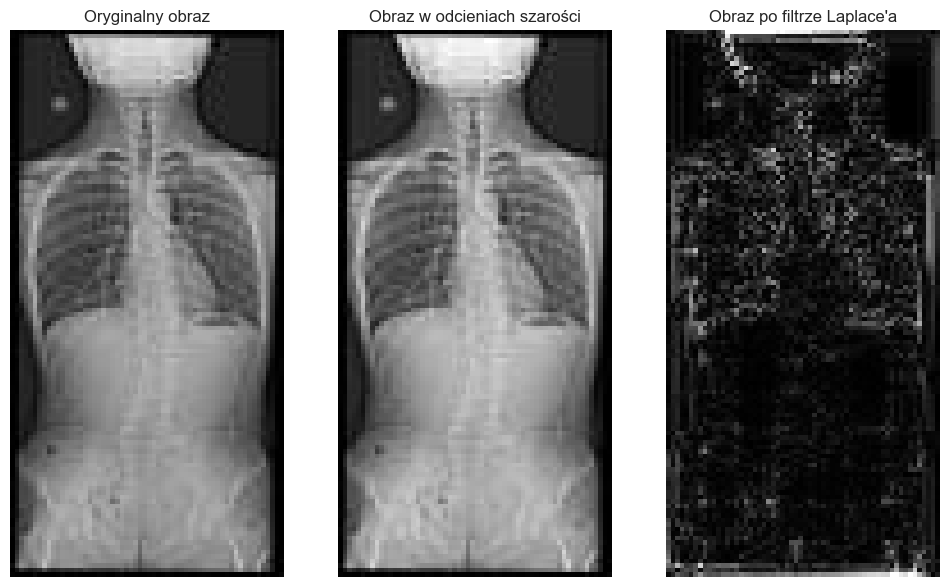

In [55]:
# Stosowanie filtru Laplace'a
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)

# Aby obrazy były bardziej czytelne, konwertujemy je z powrotem do zakresu 8-bitowego
laplacian_abs = cv2.convertScaleAbs(laplacian)

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(laplacian_abs, cmap='gray')
plt.title('Obraz po filtrze Laplace\'a')
plt.axis('off')

plt.show()

Filtr Sobela (widać jakiś zalążek kręgów)

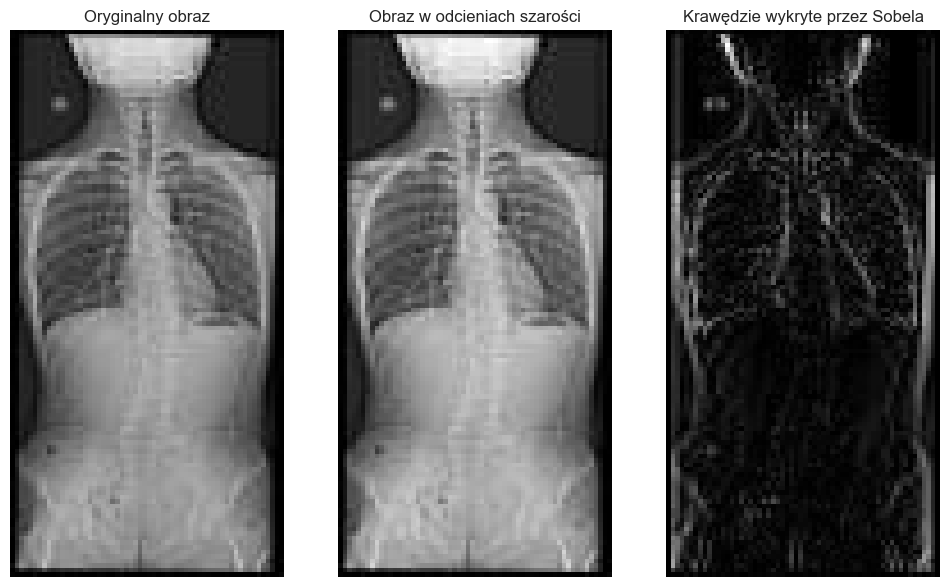

In [65]:
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=9)
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=1) 
sobel_mag_abs = cv2.convertScaleAbs(sobel_x, sobel_y)
# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_mag_abs, cmap='gray')
plt.title('Krawędzie wykryte przez Sobela')
plt.axis('off')

plt.show()

Filtr Gaussa-Laplace'a (LoG - Laplacian of Gaussian)

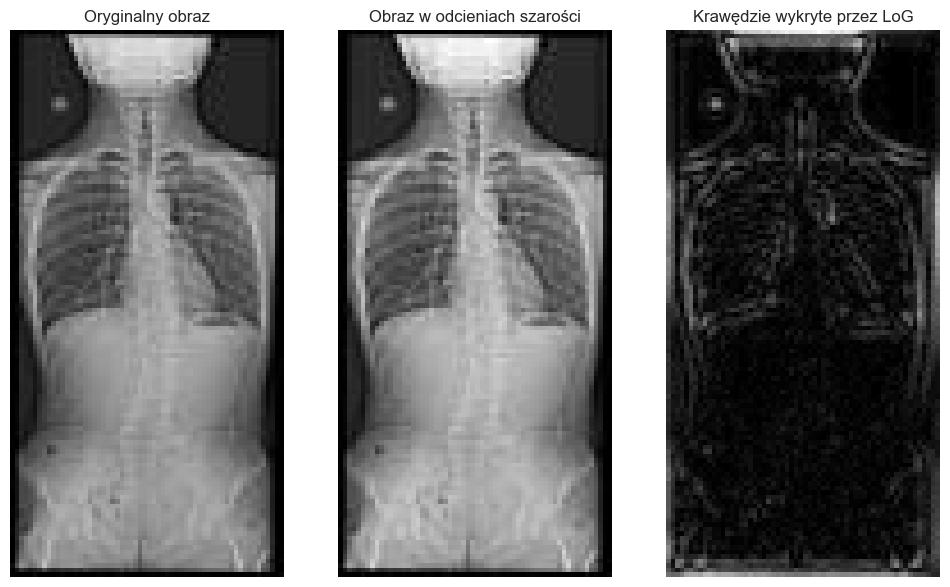

In [66]:
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

gaussian_blur = cv2.GaussianBlur(image_gray, (5, 5), 0)

laplacian_of_gaussian = cv2.Laplacian(gaussian_blur, cv2.CV_64F)

log_abs = cv2.convertScaleAbs(laplacian_of_gaussian)

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(log_abs, cmap='gray')
plt.title('Krawędzie wykryte przez LoG')
plt.axis('off')

plt.show()


Filtr Robertsa

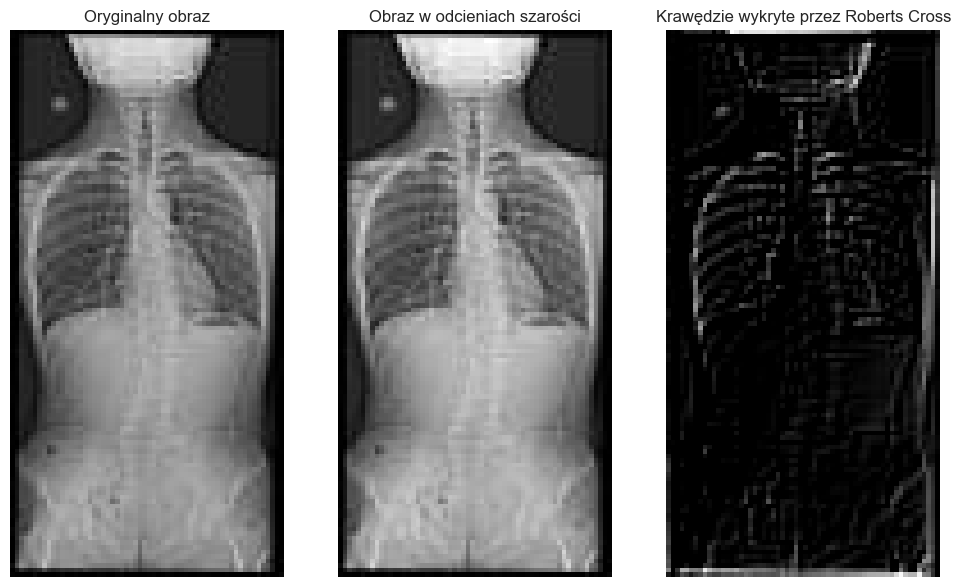

In [69]:
# Załaduj obraz i konwertuj go na odcienie szarości
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Filtry Roberts Cross w kierunkach X i Y (2x2)
kernel_x = np.array([[1, 0],
                     [0, -1]])

kernel_y = np.array([[0, 1],
                     [-1, 0]])

# Zastosowanie filtrów na obrazie
gradient_x = cv2.filter2D(image_gray, -1, kernel_x)
gradient_y = cv2.filter2D(image_gray, -1, kernel_y)

# Konwersja wyników do 8-bitowego zakresu
magnitude_abs = cv2.convertScaleAbs(gradient_x, gradient_y )

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(magnitude_abs, cmap='gray')
plt.title('Krawędzie wykryte przez Roberts Cross')
plt.axis('off')

plt.show()

Filtr Różnicy gaussów

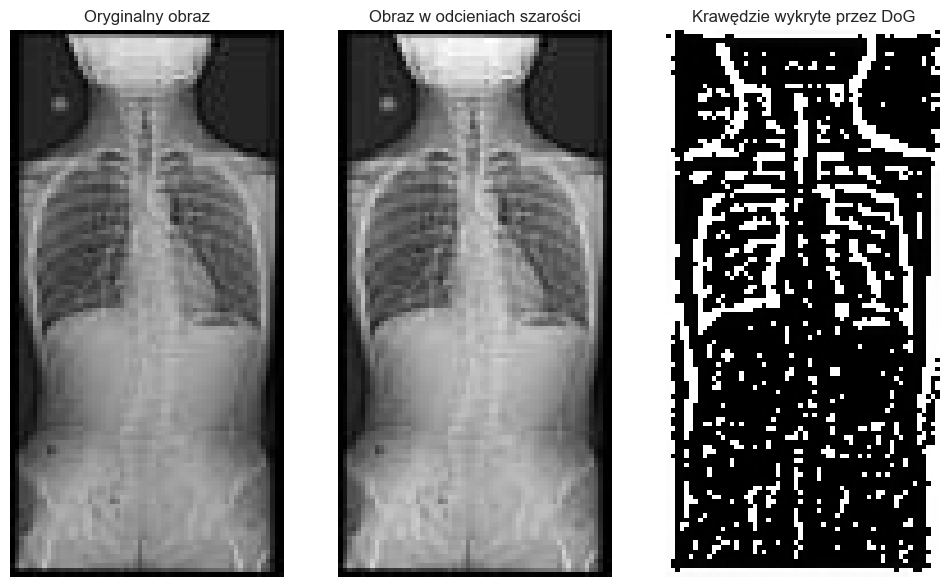

In [72]:

# Załaduj obraz i konwertuj na odcienie szarości
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Parametry do filtrów Gaussa
sigma1 = 2.0  # Pierwsze odchylenie standardowe
sigma2 = 3.0  # Drugie odchylenie standardowe (większe)

# Zastosowanie filtrów Gaussa z różnymi σ
gaussian_blur1 = cv2.GaussianBlur(image_gray, (5, 5), sigma1)
gaussian_blur2 = cv2.GaussianBlur(image_gray, (5, 5), sigma2)

# Różnica Gaussians
dog_image = gaussian_blur1 - gaussian_blur2

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dog_image, cmap='gray')
plt.title('Krawędzie wykryte przez DoG')
plt.axis('off')

plt.show()

Filtr różnicowy

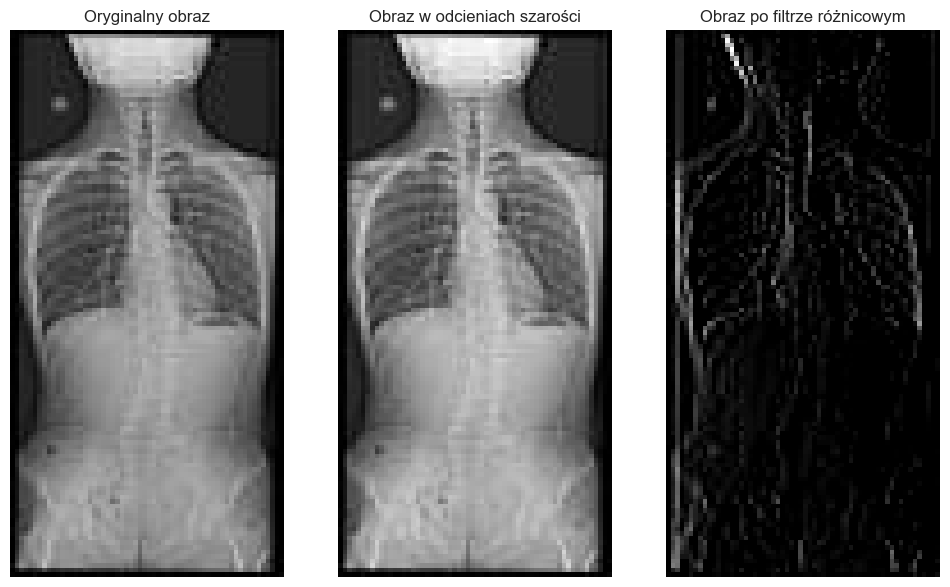

In [78]:
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

kernel = np.array([[-1, 1]])  # Filtr różnicowy w poziomie
filtered_image = cv2.filter2D(image_gray, -1, kernel)

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title('Obraz po filtrze różnicowym')
plt.axis('off')

plt.show()

Filtr gradientu kierunkowego (Directional Gradient Filter)

In [79]:
# Załaduj obraz i konwertuj go na odcienie szarości
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Funkcja do obliczania gradientu w zadanym kierunku
def directional_gradient(image, angle_degrees):
    angle_radians = np.deg2rad(angle_degrees)  # Konwersja kąta na radiany
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Maski Sobela w poziomie i pionie
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Rotacja maski Sobela o zadany kąt
    M = cv2.getRotationMatrix2D((1, 1), angle_degrees, 1.0)  # Macierz rotacji
    rotated_sobel_x = cv2.warpAffine(sobel_x, M, (sobel_x.shape[1], sobel_x.shape[0]), flags=cv2.INTER_LINEAR)
    rotated_sobel_y = cv2.warpAffine(sobel_y, M, (sobel_y.shape[1], sobel_y.shape[0]), flags=cv2.INTER_LINEAR)
    
    # Obliczanie gradientu w wybranym kierunku
    gradient_x = cv2.filter2D(image, -1, rotated_sobel_x)
    gradient_y = cv2.filter2D(image, -1, rotated_sobel_y)

    # Magnituda gradientu
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    return gradient_magnitude

# Przykład - detekcja krawędzi w kierunku 45°
angle = 45  # Kąt kierunku gradientu
gradient_image = directional_gradient(image_gray, angle)

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gradient_image, cmap='gray')
plt.title(f'Krawędzie w kierunku {angle}°')
plt.axis('off')

plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:1806: error: (-215:Assertion failed) ifunc != 0 in function 'cv::remap'


Filtr Cannyego

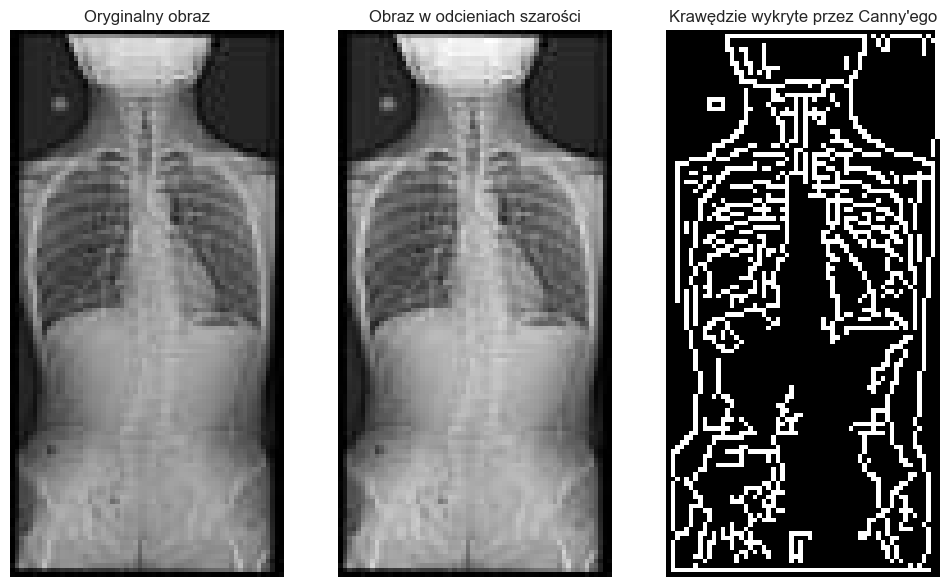

In [82]:
# Załaduj obraz i konwertuj go na odcienie szarości
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Zastosowanie filtru Canny'ego
# Pierwszy argument to obraz w odcieniach szarości, drugi i trzeci argument to progi (low, high)
edges = cv2.Canny(image_gray, threshold1=50, threshold2=200)

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Obraz w odcieniach szarości')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Krawędzie wykryte przez Canny\'ego')
plt.axis('off')

plt.show()

Łączenie filtrów Sobela,Różnicowy i Górnoprzepustowy

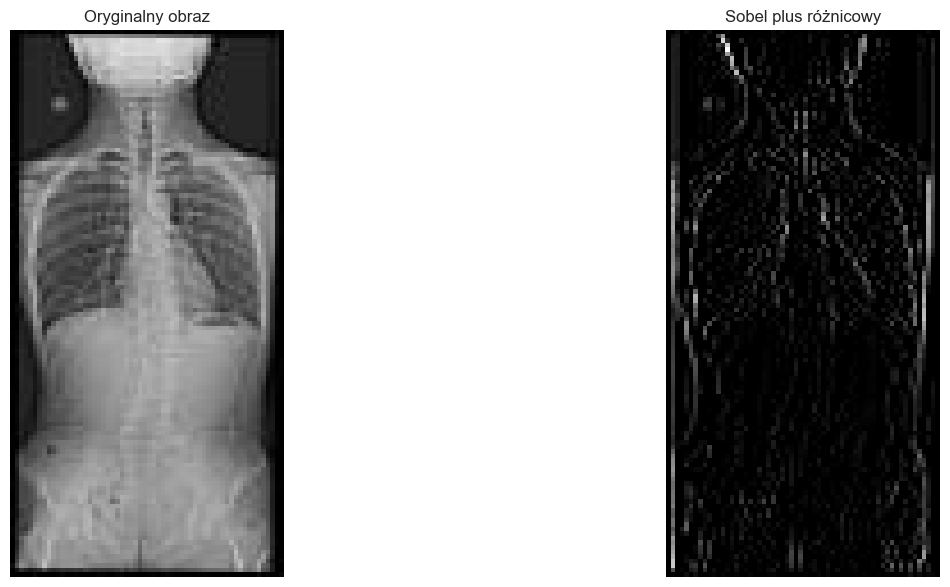

In [10]:
image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=9)
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=1) 
sobel_mag_abs = cv2.convertScaleAbs(sobel_x, sobel_y)

kernel = np.array([[-1, 1]])
filtered_image = cv2.filter2D(sobel_mag_abs, -1, kernel)

# Filtry Roberts Cross w kierunkach X i Y (2x2)
kernel_x = np.array([[1, 0],
                     [0, -1]])

kernel_y = np.array([[0, 1],
                     [-1, 0]])

# Zastosowanie filtrów na obrazie
gradient_x = cv2.filter2D(filtered_image, -1, kernel_x)
gradient_y = cv2.filter2D(filtered_image, -1, kernel_y)

# Konwersja wyników do 8-bitowego zakresu
filtered_image = cv2.convertScaleAbs(gradient_x, gradient_y )

# Wizualizacja
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Oryginalny obraz')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title('Sobel plus różnicowy')
plt.axis('off')

plt.show()

In [ ]:
# sprawdz harrisa i shi-tomasi i sift do wszystkiego  